In [1]:
import matplotlib.pylab as plt
import numpy as np
import csv

In [2]:
data = np.loadtxt("stepped_learning_curve.txt", delimiter=',', skiprows=1)
train_losses = data[:,1]
test_losses = data[:,2]
data

array([[ 0.        , 44.93092568, 28.6845317 ],
       [ 1.        , 28.22096184, 24.321011  ],
       [ 2.        , 26.24952202, 23.2528544 ],
       [ 3.        , 22.1721504 , 21.91437475],
       [ 4.        , 22.40599571, 20.35311994],
       [ 5.        , 20.86011291, 22.80566967],
       [ 6.        , 19.57633103, 17.21922682],
       [ 7.        , 20.07017409, 19.7073981 ],
       [ 8.        , 18.72678726, 15.08126686],
       [ 9.        , 18.3669349 , 16.05748048],
       [10.        , 17.007136  , 17.01407351],
       [11.        , 17.23943879, 14.54620378],
       [12.        , 16.60813737, 22.25818886],
       [13.        , 15.50234544, 13.66394172],
       [14.        , 16.52605427, 14.1376242 ],
       [15.        , 15.84616002, 13.17938365],
       [16.        , 16.05056701, 12.21337846],
       [17.        , 15.29254563, 12.3385392 ],
       [18.        , 14.88766297, 15.56652514],
       [19.        , 14.85577182, 12.53388567],
       [20.        , 14.73418122, 15.128

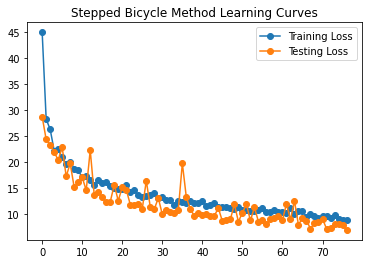

In [3]:
plt.title(f"Stepped Bicycle Method Learning Curves")
plt.plot(train_losses, marker='o', label="Training Loss")
plt.plot(test_losses, marker='o', label="Testing Loss")
plt.legend()
plt.savefig("stepped_learning.png")